The following example is meant to illustrate advanced usage of `evopython`. To begin, the package should be installed alongside `editdistance`, `matplotlib`, `pandas`, and `seaborn` and this notebook run in the same environment.

In addition, [human gene annotation data](https://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens/Homo_sapiens.GRCh38.109.chr.gtf.gz), [mouse gene annotation data](https://ftp.ensembl.org/pub/release-109/gtf/mus_musculus/Mus_musculus.GRCm39.109.gtf.gz), and the [human-mouse pairwise whole genome alignment](https://ftp.ensembl.org/pub/release-109/maf/ensembl-compara/pairwise_alignments/hsap_grch38.v.mmus_grcm39.lastz_net.tar.gz) should be downloaded from *Ensembl*; human-mouse ortholog data, processed from [The Alliance of Genome Resources](https://www.alliancegenome.org/downloads#orthology), is provided.

We have to perform two pre-processing steps to get the alignment data ready for use: first, the files must be merged on chromosome name; and second, we need to fix the `score` field (which is malformed as of release 109). A command-line script that does both can be found [here](https://gist.github.com/steven-mick/ed7810edfedb3c8c5c7b6da974445b28); once the above human-mouse alignment has been downloaded and the data extracted, simply run `python prepare_wga.py --maf-dir path/to/dir --method lastz_net`.

Below, I assume the human-mouse alignment directory is inside the current working directory and named `hsap_mmus`. To begin, let's initialize our classes:

In [4]:
from evopython import GTF, MAF

human_genes = GTF("Homo_sapiens.GRCh38.109.chr.gtf", types=("transcript", "exon"))
mouse_genes = GTF("Mus_musculus.GRCm39.109.chr.gtf", types=("transcript",))

wga = MAF("hsap_mmus", aligned_on="homo_sapiens")

Adding `types=("transcript", "exon")` instructs `GTF` to parse transcript and exon features in addition to the default gene features—note that the argument must be a `tuple`, hence the `,` after `"transcript"` for `mouse_genes`. Any number of feature types are allowed, and querying has the general form `gtf_instance[gene_name][feature_type]`, which accesses the set of `Feature` instances of type `feature_type` belonging to gene `gene_name`, e.g,

In [5]:
for exon in human_genes['HES3']['exon']:
    print(exon.locus(base=0))

1:6244547-6244629
1:6244350-6244446
1:6245109-6245578
1:6244178-6244241


The provided `human_mouse_orthologs.csv` is a two-column, comma-separated file, where column 1 is the human gene name and column 2 the orthologous mouse gene name. Let's read it into a dictionary:

In [6]:
import csv

human_mouse_ortholog = dict()
with open("human_mouse_orthologs.csv", 'r') as f:
    reader = csv.reader(f)

    for row in reader:
        human_gene, mouse_gene = row
        human_mouse_ortholog[human_gene] = mouse_gene

Now, suppose we wanted to explore the connection between splice-site mutation and changes in isoform number since the human and mouse lineages diverged. We can iterate over the human gene set; check whether each gene is both protein-coding and has a protein-coding ortholog in the mouse genome; and derive the set of unique splice sites from the genes’ constituent exon features in a manner analogous to how we derived the HES3 core promoter in the `primats.ipynb` notebook:


In [7]:
import editdistance

long_data = []
for gene_name in human_genes:
    human_gene = human_genes[gene_name]

    if gene_name not in human_mouse_ortholog:
        continue  # No ortholog.
    else:
        orthologous_gene = human_mouse_ortholog[gene_name]

    if orthologous_gene not in mouse_genes:
        continue  # No annotation.
    else:
        mouse_gene = mouse_genes[orthologous_gene]

    human_biotype = human_gene['attr']['gene_biotype']
    mouse_biotype = mouse_gene['attr']['gene_biotype']

    if {human_biotype, mouse_biotype} != {"protein_coding"}:
        continue  # Not both protein-coding.

    human_isoform_count = len(human_gene['transcript'])
    mouse_isoform_count = len(mouse_gene['transcript'])

    isoform_change = abs(human_isoform_count - mouse_isoform_count)

    ss3_feats = set()
    ss5_feats = set()

    for feat in human_gene['exon']:
        ss3_feats.add(feat.pad(center=5, pad5=20, pad3=3))
        ss5_feats.add(feat.pad(center=3, pad5=6, pad3=3))

    edit_dist = 0
    for site, features in zip((5, 3), (ss5_feats, ss3_feats)):
        size = 23 if site == 3 else 9

        for feat in ss3_feats:
            alignments = wga.get(feat, match_strand=True)

            if len(alignments) == 1:
                alignment, = alignments
            else:
                # Ignore the alignment if it's not contiguous.
                continue

            _, human_seq = alignment['homo_sapiens']
            _, mouse_seq = alignment['mus_musculus']

            edit_dist += editdistance.eval(human_seq, mouse_seq) / size

    long_data.append({
        'edit_dist': edit_dist,
        'isoform_change': isoform_change
    })

`match_strand=True` is the default behavior and ensures the aligned sequence corresponds to the same strand as the feature in the `aligned_on` species, but in these types of analyses especially, it can be helpful to be explicit that we're retrieving *stranded* sequences. The splice site regions are based on [MaxEntScan](http://hollywood.mit.edu/burgelab/maxent/Xmaxentscan_scoreseq.html).

Now that we populated our `long_data` list, we can proceed with plotting:

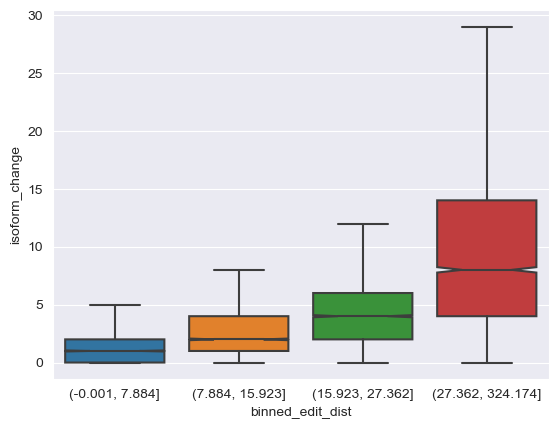

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

frame = pd.DataFrame(long_data)
frame['binned_edit_dist'] = pd.qcut(frame.edit_dist.values, q=4)

sns.boxplot(
    data=frame,
    x="binned_edit_dist",
    y="isoform_change",
    showfliers=False,
    notch=True
)

plt.show()